# 1) Importing Necesseary Libraries & PreProcessing

In this section we will:


*   Import 'spam.csv' from Drive (The dataset can be found: https://www.kaggle.com/datasets/shantanudhakadd/email-spam-detection-dataset-classification/data)
*   Check out the dataset

*   Clean up the dataset, including: removing missing values, renaming tables



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas nltk scikit-learn matplotlib seaborn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

In [ ]:
data_frame = pd.read_csv('/content/drive/MyDrive/spam.csv', encoding='latin1')
data_frame.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data_frame = data_frame.rename(columns={'v1': 'Category', 'v2': 'Message'})[['Category', 'Message']]

le = LabelEncoder()
data_frame['Category'] = le.fit_transform(data_frame['Category'])


data_frame.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
missing_values = data_frame.isnull().sum()

print(f"Number of missing values:\n {missing_values}")
print("-"*30)

print(f"Shape of data frame {data_frame.shape}")
print("-"*30)


data_frame.dropna(inplace=True)
missing_values_after_drop = data_frame.isnull().sum()
print(f"Number of missing values after dropping: {missing_values_after_drop}")
print("-"*30)

data_frame.head()

Number of missing values:
 Category    0
Message     0
dtype: int64
------------------------------
Shape of data frame (5572, 2)
------------------------------
Number of missing values after dropping: Category    0
Message     0
dtype: int64
------------------------------


,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [ ]:
data_frame['Message'] = data_frame['Message'].apply(clean_text)

# 2) Training With Multinominal Naive Bayes



*   For the training part, multinomial naive bayes selected for several reaons for instance, it is  suitable for word counts for text classification [text classification](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB), and it is simple and faster.


*   Test size set to 30%, since the used dataset contains around 5k lines, selected test size would be the best.

Test Size: 10.0%
--------------------------------------------------
Test Size: 20.0%
--------------------------------------------------
Test Size: 25.0%
--------------------------------------------------
Test Size: 30.0%
--------------------------------------------------
Test Size: 40.0%
--------------------------------------------------

Perfomation Comparision Table:

   Test Size  Train Samples  Test Samples  Accuracy  Spam Precision  \
0       0.10           5014           558    0.9731          1.0000   
1       0.20           4457          1115    0.9722          0.9917   
2       0.25           4179          1393    0.9742          0.9935   
3       0.30           3900          1672    0.9743          0.9892   
4       0.40           3343          2229    0.9686          0.9751   

   Spam Recall  Spam F1-Score  Weighted Avg Precision  Weighted Avg Recall  \
0       0.8000         0.8889                  0.9739               0.9731   
1       0.7987         0.8848               

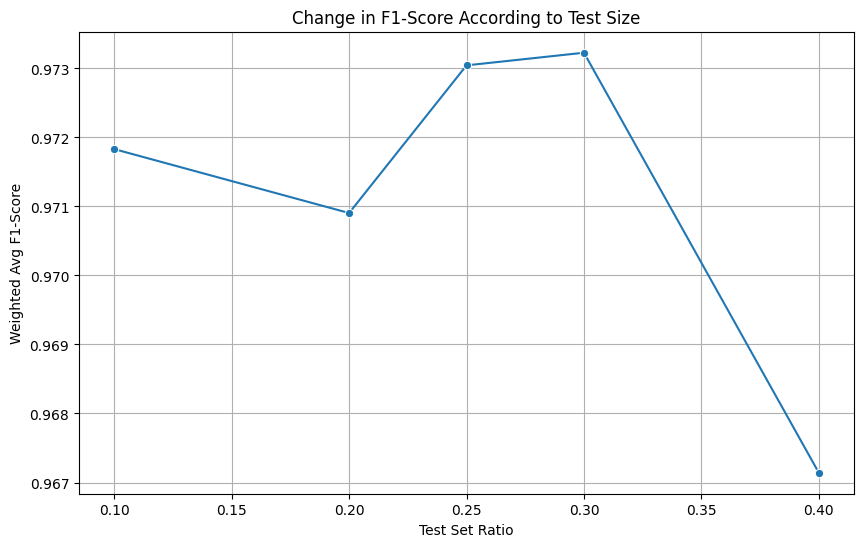

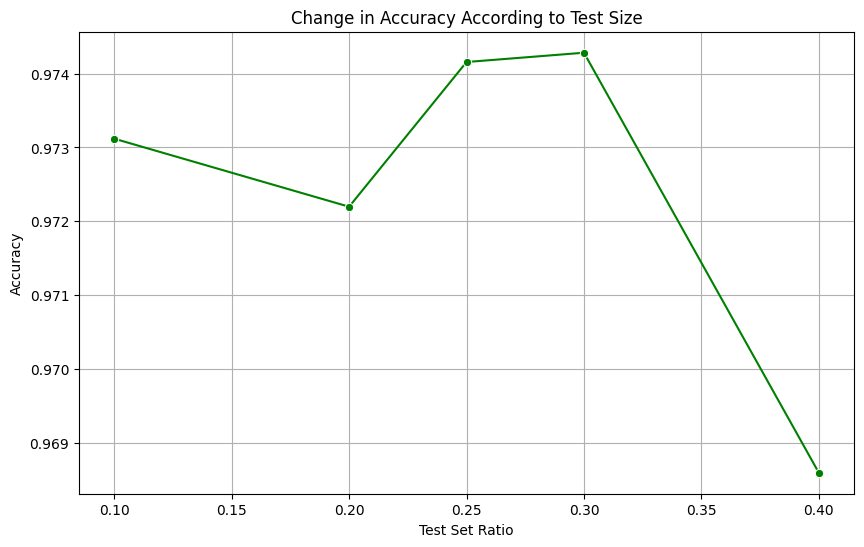

In [ ]:
X = data_frame['Message']
y = data_frame['Category']

my_stop_words = set(stopwords.words('english'))

vectorizer_params = {
    'max_features': 5000,
    'min_df': 5,
    'stop_words': list(my_stop_words)
}

test_sizes = [0.1, 0.2, 0.25, 0.3, 0.4]

results = []


for ts in test_sizes:
    print(f"Test Size: {ts*100}%")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=ts, random_state=42, stratify=y
    )

    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    model = MultinomialNB()
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    spam_precision = report['1']['precision'] # precision for 'spam'
    spam_recall = report['1']['recall']     # recall for 'spam'
    spam_f1_score = report['1']['f1-score'] # f-1 for 'spam'

    weighted_precision = report['weighted avg']['precision']
    weighted_recall = report['weighted avg']['recall']
    weighted_f1_score = report['weighted avg']['f1-score']

    results.append({
        'Test Size': ts,
        'Train Samples': len(X_train),
        'Test Samples': len(X_test),
        'Accuracy': accuracy,
        'Spam Precision': spam_precision,
        'Spam Recall': spam_recall,
        'Spam F1-Score': spam_f1_score,
        'Weighted Avg Precision': weighted_precision,
        'Weighted Avg Recall': weighted_recall,
        'Weighted Avg F1-Score': weighted_f1_score
    })
    print("-" * 50)

results_df = pd.DataFrame(results)
print("\nPerfomation Comparision Table:\n")
print(results_df.round(4))

plt.figure(figsize=(10, 6))
sns.lineplot(x='Test Size', y='Weighted Avg F1-Score', data=results_df, marker='o')
plt.title('Change in F1-Score According to Test Size')
plt.xlabel('Test Set Ratio')
plt.ylabel('Weighted Avg F1-Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Test Size', y='Accuracy', data=results_df, marker='o', color='green')
plt.title('Change in Accuracy According to Test Size')
plt.xlabel('Test Set Ratio')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In previous step, multiple test sizes compared and according to comparision charts, best results achieved with 30% test size.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

my_stop_words = set(stopwords.words('english'))

vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    stop_words=list(my_stop_words)
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)
nb_accuracy = accuracy_score(y_test, y_pred)
nb_report = classification_report(y_test, y_pred, output_dict=True)




--- Multinomial Naive Bayes Results ---
Accuracy: 0.9743
------------------------------
Weighted F1 Score: 0.9732
------------------------------


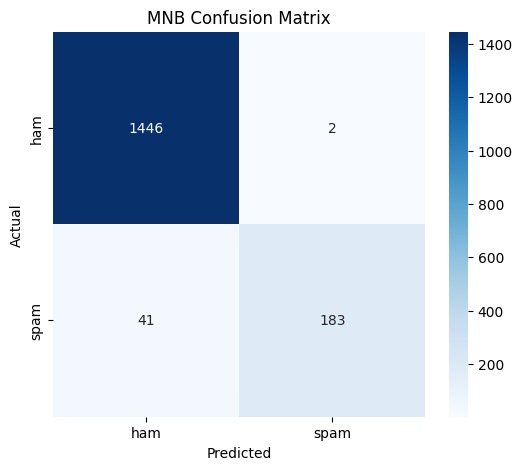

{'0': {'precision': 0.972427706792199, 'recall': 0.9986187845303868, 'f1-score': 0.9853492333901193, 'support': 1448.0}, '1': {'precision': 0.9891891891891892, 'recall': 0.8169642857142857, 'f1-score': 0.8948655256723717, 'support': 224.0}, 'accuracy': 0.9742822966507177, 'macro avg': {'precision': 0.9808084479906941, 'recall': 0.9077915351223362, 'f1-score': 0.9401073795312455, 'support': 1672.0}, 'weighted avg': {'precision': 0.9746732642425134, 'recall': 0.9742822966507177, 'f1-score': 0.9732270141743444, 'support': 1672.0}}


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Multinomial Naive Bayes Results ---")
print(f"Accuracy: {nb_accuracy:.4f}")

print("-"*30)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")
print("-"*30)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('MNB Confusion Matrix')
plt.show()


print(nb_report)

# 3) Fine Tuned Transformer Comparision (Naive Bayes vs BERT)

In this section


*   Used Distilbert
*   Tokenized
*   Naive Bayes and BERT transformer results compared



In [ ]:
!pip install --upgrade datasets transformers torch evaluate numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
!pip install --upgrade torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1 which is incompatible.


In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import InputExample, InputFeatures
from datasets import Dataset
import evaluate
import numpy as np

[DistilBERT] (https://huggingface.co/distilbert/distilbert-base-uncased) used because it is faster, and smaller than BERT. Also it is trained using raw texts and case sensitivity is dismissed.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'labels': y_train.tolist()})
test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'labels': y_test.tolist()})

Map:   0%|          | 0/3900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1672 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.086800,0.080188,0.980861
2,0.037900,0.063228,0.983254
3,0.023200,0.067452,0.985646



--- Fine-Tuned BERT Results ---
Accuracy: 0.9856
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.97      0.92      0.95       224

    accuracy                           0.99      1672
   macro avg       0.98      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672



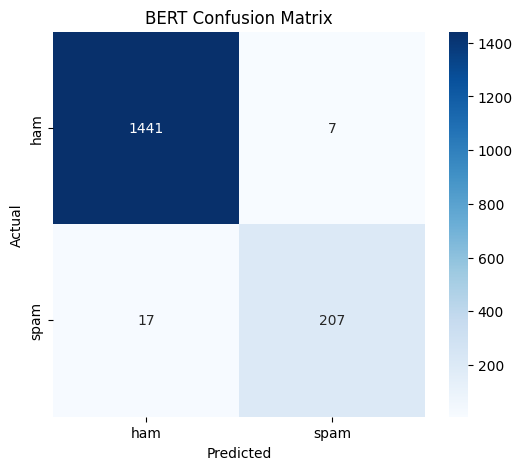

In [ ]:

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["text"])

tokenized_train_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

bert_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

predictions_bert = trainer.predict(tokenized_test_dataset)
y_pred_bert = np.argmax(predictions_bert.predictions, axis=-1)

target_names = ['ham', 'spam']
bert_accuracy = accuracy_score(y_test, y_pred_bert)
bert_report = classification_report(y_test, y_pred_bert, target_names=target_names, output_dict=True)

print("\n--- Fine-Tuned BERT Results ---")
print(f"Accuracy: {bert_accuracy:.4f}")
print(classification_report(y_test, y_pred_bert, target_names=target_names))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_bert), annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BERT Confusion Matrix')
plt.show()




---Model Perfomance Comparision Table ---
                     Model  Accuracy  Precision (Spam)  Recall (Spam)  \
0  Multinomial Naive Bayes    0.9743            0.9892         0.8170   
1          Fine-Tuned BERT    0.9856            0.9673         0.9241   

   F1-Score (Spam)  Weighted Avg Precision  Weighted Avg Recall  \
0           0.8949                  0.9747               0.9743   
1           0.9452                  0.9855               0.9856   

   Weighted Avg F1-Score  
0                 0.9732  
1                 0.9855  


<ipython-input-22-8159490f688a>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df, ax=ax[0], palette='viridis')
<ipython-input-22-8159490f688a>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Weighted Avg F1-Score', data=comparison_df, ax=ax[1], palette='plasma')


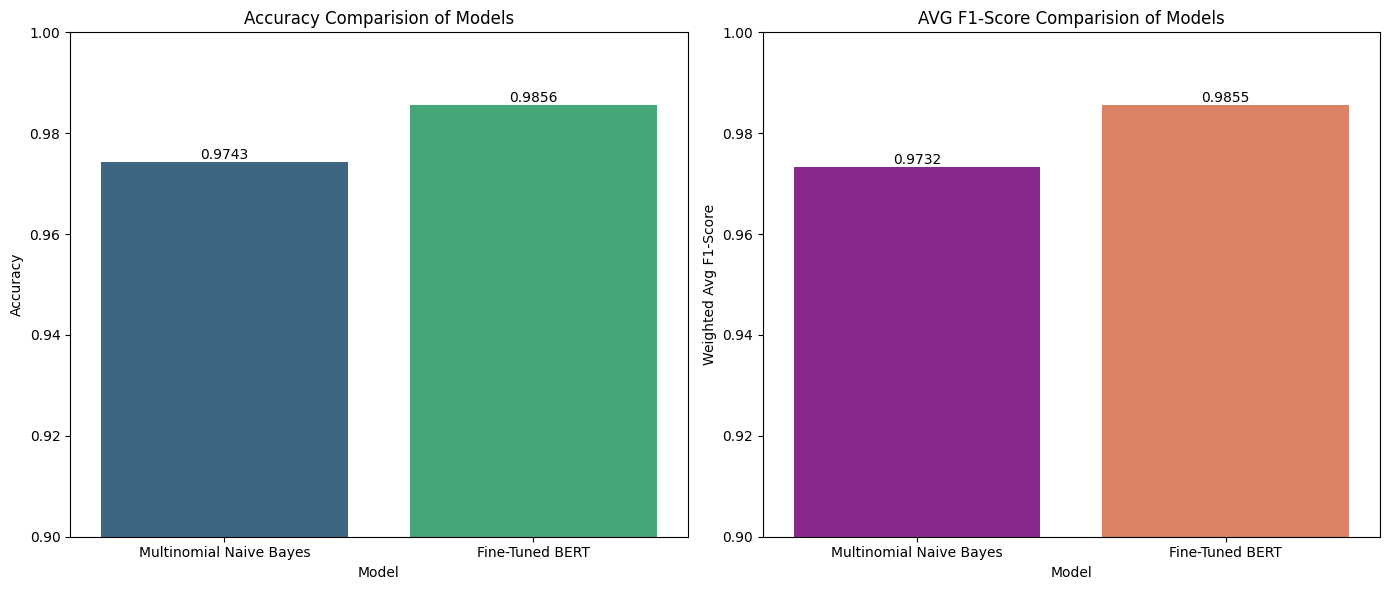

In [ ]:
# Used 1 for spam metrics
comparison_data = {
    'Model': ['Multinomial Naive Bayes', 'Fine-Tuned BERT'],
    'Accuracy': [nb_accuracy, bert_accuracy],
    'Precision (Spam)': [nb_report['1']['precision'], bert_report['spam']['precision']],
    'Recall (Spam)': [nb_report['1']['recall'], bert_report['spam']['recall']],
    'F1-Score (Spam)': [nb_report['1']['f1-score'], bert_report['spam']['f1-score']],
    'Weighted Avg Precision': [nb_report['weighted avg']['precision'], bert_report['weighted avg']['precision']],
    'Weighted Avg Recall': [nb_report['weighted avg']['recall'], bert_report['weighted avg']['recall']],
    'Weighted Avg F1-Score': [nb_report['weighted avg']['f1-score'], bert_report['weighted avg']['f1-score']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n---Model Perfomance Comparision Table ---")
print(comparison_df.round(4))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Model', y='Accuracy', data=comparison_df, ax=ax[0], palette='viridis')
ax[0].set_title('Accuracy Comparision of Models')
ax[0].set_ylim(0.9, 1.0)
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

sns.barplot(x='Model', y='Weighted Avg F1-Score', data=comparison_df, ax=ax[1], palette='plasma')
ax[1].set_title('AVG F1-Score Comparision of Models')
ax[1].set_ylim(0.9, 1.0)
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()